#The wave equation in 1D

$$
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\drondtt}{\partial_{tt}}
\newcommand{\drondxx}{\partial_{xx}}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this practical work session, we test a very classical lattice Boltzmann scheme $\DdQq{1}{3}$ on the wave equation.

The problem reads
$$ \drondtt\rho = c^2 \drondxx\rho, \qquad t>0, \quad x\in(0,2\pi),$$
where $c$ is a constant scalar. In this session, two different kinds of boundary conditions will be considered:
* periodic conditions $\rho(0)=\rho(2\pi)$,
* Homogeneous Dirichlet conditions $\rho(0)=\rho(2\pi)=0$.

The problem is transformed into a one order system:

\begin{aligned} &\drondt \rho + \drondx q = 0, && t>0, \quad x\in(0, 2\pi),\\ &\drondt q + c^2 \drondx \rho = 0, && t>0, \quad x\in(0, 2\pi).\end{aligned}


##The scheme $\DdQq{1}{3}$

The numerical simulation of this equation by a lattice Boltzmann scheme consists in the approximation of the solution on discret points of $(0,2\pi)$ at discret instants.

The spatial mesh is defined by using a numpy array. To simplify, the mesh is supposed to be uniform.

####Question 1

First, import the package numpy and create the spatial mesh. One phantom cell has to be added at each bound for the treatment of the boundary conditions.

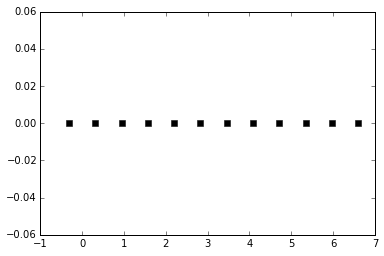

In [1]:
import numpy as np
%matplotlib inline 
import pylab as plt

def mesh(N):
    xmin, xmax = 0., 2.*np.pi
    dx = (xmax-xmin)/N
    x = np.linspace(xmin-.5*dx, xmax+.5*dx, N+2)
    return x

x = mesh(10)
plt.plot(x, 0.*x, 'sk')
plt.show()

To simulate this system of equations, we use the $\DdQq{1}{3}$ scheme given by

* three velocities $v_0=0$, $v_1=1$, and $v_2=-1$, with associated distribution functions $\fk{0}$, $\fk{1}$, and $\fk{2}$,
* a space step $\dx$ and a time step $\dt$, the ration $\lambda=\dx/\dt$ is called the scheme velocity,
* three moments
  $$ \mk{0}=\sum_{i=0}^{2} \fk{i}, \quad \mk{1}= \lambda \sum_{i=0}^{2} v_i \fk{i}, \quad \mk{2}= \frac{\lambda^2}{2} \sum_{i=0}^{2} v_i^2 \fk{i},$$
  and their equilibrium values $\mke{0} = \mk{0}$, $\mke{1} = \mk{1}$, and $\mke{2} = c^2/2 \mk{0}$.
* a relaxation parameter $s$ lying in $[0,2]$.

In order to prepare the formalism of the package pyLBM, we introduce the three polynomials that define the moments: $P_0 = 1$, $P_1=\lambda X$, and $P_2=\lambda^2/2 X^2$, such that
$$ \mk{k} = \sum_{i=0}^2 P_k(v_i) \fk{i}.$$
The transformation $(\fk{0}, \fk{1}, \fk{2})\mapsto(\mk{0},\mk{1}, \mk{2})$ is invertible if, and only if, the polynomials $(P_0,P_1,P_2)$ is a free set over the stencil of velocities.

The lattice Boltzmann method consists to compute the distribution functions $\fk{0}$, $\fk{1}$, and $\fk{2}$ in each point of the lattice $x$ and at each time $t^n=n\dt$.
A step of the scheme can be read as a splitting between the relaxation phase and the transport phase:

* relaxation: 
    $$\mks{2}(t,x)=(1-s)\mk{2}(t,x)+s\mke{2}(t,x).$$
* m2f: 
    \begin{aligned}\fks{0}(t,x)&\;=\mk{0}(t,x)-2\mks{2}(t,x)/\lambda^2, \\ \fks{1}(t,x)&\;=\mk{1}(t,x)/(2\lambda)+\mks{2}(t,x)/\lambda^2, \\ \fks{2}(t,x)&\;=-\mk{1}(t,x)/(2\lambda)+\mks{2}(t,x)/\lambda^2.\end{aligned}
* transport: 
    \begin{aligned} \fk{0}(t+\dt, x)&\;=\fks{0}(t,x), \\ \fk{1}(t+\dt, x)&\;=\fks{1}(t,x-\dx), \\ \fk{2}(t+\dt, x)&\;=\fks{2}(t,x+\dx). \end{aligned}
* f2m: 
    \begin{aligned}\mk{0}(t+\dt,x)&\;=\fk{0}(t+\dt,x)+\fk{1}(t+\dt,x)+\fk{2}(t+\dt,x), \\ \mk{1}(t+\dt,x)&\;=\lambda\fk{1}(t+\dt,x)-\lambda\fk{2}(t+\dt,x), \\ \mk{2}(t+\dt,x)&\;=\tfrac{1}{2}\lambda^2\fk{1}(t+\dt,x)+\tfrac{1}{2}\lambda^2\fk{2}(t+\dt,x).\end{aligned}

The moments of order $0$, $\mk{0}$, and of order $1$, $\mk{1}$, being conserved during the relaxation phase, the equivalent equations of this scheme read at first order

\begin{aligned}&\drondt\mk{0} + \drondx\mk{1} = \grandO(\dt),\\ &\drondt\mk{1} + 2\drondx\mke{2} = \grandO(\dt). \end{aligned}

####Question 2

Propose a function equilibrium that computes the equilibrium value $\mke{2}$, the moment of order $0$, $\mk{0}$, and the velocity $c$ being given in argument.

####Question 3

Create three vectors $\mk{0}$, $\mk{1}$, and $\mk{2}$ with shape the shape of the mesh and initialize them. The moments of order $0$ and $1$ should contain the initial value of the unknowns $\rho$ and $q$, and the moment of order $2$ the corresponding equilibrium value.

Create also three vectors $\fk{0}$, $\fk{1}$ and $\fk{2}$.

## Periodic boundary conditions

####Question 4
Propose the four elementary functions f2m, relaxation, m2f, and transport. In the transport function, the boundary conditions should be implemented: we will use periodic conditions by copying the informations in the phantom cells.

####Question 5

Compute and plot the numerical solution at time $T_f=2\pi$.

In [2]:
def equilibrium(m0, c):
    pass

def initialize(mesh, c, la):
    pass

def f2m(f0, f1, f2, m0, m1, m2, la):
    pass

def m2f(f0, f1, f2, m0, m1, m2, la):
    pass

def relaxation(m0, m1, m2, c, s):
    pass

def transport(f0, f1, f2):
    pass

# parameters
c = 1   # velocity for the transport equation
Tf = 2*np.pi # final time
N = 128 # number of points in space
la = 1. # scheme velocity
s = 2.  # relaxation parameter
# initialization
#...

##Anti bounce back conditions

In order to take into account homogenous Dirichlet conditions over $\rho$, we introduce the bounce back conditions. At edge $x=0$, two points are involved: $x_0=-\dx/2$ and $x_1=\dx/2$. We impose $\fk{1}(x_0)=-\fk{2}(x_1)$. And at edge $x=2\pi$, the two involved points are $x_{N}$ and $x_{N+1}$. We impose $\fk{2}(x_{N+1})=-\fk{1}(x_{N})$.

####Question 7

Modify the transport function to impose anti bounce back conditions. Compare the solutions obtained with the two different boundary conditions.

In [3]:
def transport(f0, f1, f2):
    pass

# parameters
c = 1   # velocity for the transport equation
Tf = 2*np.pi # final time
N = 128 # number of points in space
la = 1. # scheme velocity
s = 2.  # relaxation parameter
# initialization
#...

In [6]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()